# DATA20001 Deep Learning - Group Project
## Image project


The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

## Get the data

The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

Datafiles were unzipped with bash commands instead of the provided code snippet and tensorflow was used from thereout.

In [5]:
from pathlib import Path
from PIL import Image
import tensorflow.keras as tfk
import tensorflow as tf
import numpy as np
import pandas as pd
import IPython.display as display
import matplotlib.pyplot as plt
import os
from collections import defaultdict

In [6]:
# Check the tensorflow version we're using and device counts
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

2.0.0
Num GPUs Available:  0
Num CPUs Available:  1


In [7]:
# Get current working directory.
root = Path(os.getcwd())

# Define paths to the image data directory and labels directory
im_dir = root/'train'/'images'
label_dir = root / 'train' / 'annotations'

# Sort labels by alphabetical order and cast the iterator to list. 
# This is done so the order stays fixed for one hot encoded labels later
labelpath_list = sorted(list(label_dir.iterdir()))


# Get size of the data set, number of labels and define batch size
CLASS_NUM = len(labelpath_list)
DATASET_SIZE = len(list(im_dir.iterdir()))
BATCH_SIZE = 128

FileNotFoundError: [WinError 3] Määritettyä polkua ei löydy: 'C:\\Users\\Aleksi\\Documents\\hy-opinnot\\Deep_learning\\train\\annotations'

In [ ]:
def calculate_class_weights(images, labels, number_of_classes):
    # Initalize weights for each label
    TOTAL = len(images)*number_of_classes
    class_weights = np.zeros(number_of_classes)
    pos =0 
    for i, file in enumerate(labels):
        with open(file) as f:
            for line in f:
                class_weights[i] += 1
                pos += 1
    weights_from_counts = np.vectorize(lambda x: (1/x)*TOTAL/2)
    class_weights = weights_from_counts(class_weights)
    init = tf.lookup.KeyValueTensorInitializer(list(range(number_of_classes)), class_weights.astype(np.float32))
    return tf.lookup.StaticHashTable(init, tf.constant(1/(TOTAL-pos)*TOTAL/2,dtype=tf.float32))
    
class_weights = calculate_class_weights(list(im_dir.iterdir()),labelpath_list, CLASS_NUM )

In [ ]:
class_weights.lookup(tf.constant(13))

In [ ]:
def get_label_map(label_paths):
    '''
    Creates a lookup table for efficiently connecting image ids with their labels.
    '''
    
    # Tensorflow StaticHashTable doesn't work with values that are multidimensional tensors.
    # The labels parsed from file are therefore stored in strings
    label_map = defaultdict(str)
    
    
    # Iterate over the label files. Store the index of each label to a dictionary under the ids in the file.
    for i, path in enumerate(label_paths):
         with open(path) as f:
                for line in f:
                    key = line.strip()
                    label_map[key] += str(i) +' '
                    
    keys = list(label_map.keys())
    values = list(label_map.values())
    
    # Initialize the lookup table and set -1 as the default value to be used if the key is not found in the table.
    init = tf.lookup.KeyValueTensorInitializer(keys,values)
    return tf.lookup.StaticHashTable(init, tf.constant('-1'))

# Create the lookup table for later use
label_map = get_label_map(labelpath_list)

In [ ]:
def get_id(file_path):
    '''
    Gets the id number of an image file from a file path. Input is expected to be a string tensor.
    '''
    
    # Split the tensor by the system path separator
    parts = tf.strings.split(file_path, os.path.sep)
    
    # Get the file name 
    file_name = parts[-1]
    
    # Remove the im and .jpeg around the id in the file name
    img_id = tf.strings.regex_replace(file_name, r'(im)|(\.jpg)','')
    return img_id


# Sanity checks
ids = get_id('/scratch/project_2002958/Deep_learning/train/images/im5.jpg')
ids

In [ ]:
def calc_weight(int_labels, class_weights):
    return tf.reduce_max(class_weights.lookup(int_labels))

In [ ]:
def get_label_and_weights(img_id, label_map, num_classes, class_weights=class_weights):
    '''
    Looks up the label of an image from the label map based on it's id and encodes the label into one hot format.
    '''
    # Look up the label
    string_labels = label_map.lookup(img_id)
    
    # Covert the string into a list
    list_labels = tf.strings.split([string_labels])
    
    # Cast the elements in the list into int
    int_labels = tf.strings.to_number(list_labels.values, tf.int32)
    weight = calc_weight(int_labels, class_weights)
    # Convert the list of int elements into one hot arrays. 
    # By default tensorflow returns one hot arrays in matrix in the form (number_of_correct labels, num_classes)
    # with one non-zero value for each row.
    one_hot = tf.one_hot(int_labels, num_classes, 1, 0)
    # Flatten the returned one hot arrays into 1 dimensional array. 
    return tf.reduce_max(one_hot,0), weight

get_label_and_weights(ids, label_map,14)

In [ ]:
def decode_img(img):
    '''
    Decodes the image files
    '''
    # Use jpeg encoding with 3 channels for rgb values
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Cast pixel values to float and limit their range to [0,1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # Resize the images to 128x128 just in case
    img = tf.image.resize(img,(128,128))
    
    # Standardize the images to have mean 0 and variance of 1
    return tf.image.per_image_standardization(img)

In [ ]:
def preprocess_path(file_path):
    '''
    Converts the file path dataset into a set of image data and their labels
    '''
    # Parse the id of an image from it's file path
    img_id = get_id(file_path)
    
    # Attach a label to that image
    label, weight = get_label_and_weights(img_id, label_map, len(labelpath_list))
    
    # Read the image from file
    img = tf.io.read_file(file_path)
    
    # preprocess the image to usable form
    img = decode_img(img)
    return img, label, weight

In [ ]:
def prepare_dataset(ds, aug=False):
    '''
    Prepares the dataset
    '''
    # Cache the dataset. Mostly here so the cache can be directed to a file if necessary
    ds = ds.cache()
    
    # Shuffle the samples
    ds = ds.shuffle(1000)
    
    # Prevent the dataset from being exhausted completely
    ds = ds.repeat()
    
    if aug:
        ds = ds.map(data_aug,  num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Define batch size
    ds = ds.batch(BATCH_SIZE)
    
    # Allow fetching batches while training
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds


In [ ]:
def data_aug(img, label, weight):
    '''
    Augments the images to prevent overfitting and get more samples
    '''
    # Apply the following transformations randomly to the images: 
    # flip image horizontally, flip image vertically, adjust hue
    aug_img = tf.image.random_flip_left_right(img)
    aug_img = tf.image.random_flip_up_down(aug_img)
    aug_img = tf.image.random_hue(aug_img, 0.2)

    return tf.image.resize(aug_img,[128,128]), label, weight

In [ ]:
def generate_dataset(image_directory):
    '''
    Generates a tensorflow dataset from a path to the image directyory
    '''
    
    # Create a dataset from the file names
    img_ds = tf.data.Dataset.list_files(str(image_directory/'*'))
    
    # Transform the filename dataset into a dataset containing pairs of image data and labels
    return img_ds.map(preprocess_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [4]:
# Set validation and test size and generate the data sets for training, validation and testing. 
# Validation size here is size of the validation dataset - the size of the test dataset
VALIDATION_SIZE = 3000
TEST_SIZE = 1000
full_ds = generate_dataset(im_dir).shuffle(1000)

val_ds = full_ds.take(VALIDATION_SIZE)
test_ds = prepare_dataset(val_ds.take(TEST_SIZE))
val_ds = prepare_dataset(val_ds.skip(TEST_SIZE))

# We want to apply data-augmentation to the training set
train_ds = prepare_dataset(full_ds.skip(VALIDATION_SIZE), aug=True)

NameError: name 'generate_dataset' is not defined

In [16]:
# Calculate the initial bias to help the model converge with imbalanced data

POS = np.zeros(CLASS_NUM)

for i,path in enumerate(labelpath_list):
    with open(path) as f:
        for line in f:
            POS[i] += 1

NEG = DATASET_SIZE*14-POS

initial_bias = tf.constant_initializer(np.log(POS/NEG))

In [17]:
# Define the model and compile it
# We are using convolution followed by a dense layer to "interpret" the results before the final output layer
model = tfk.Sequential([
    tfk.layers.Conv2D(64,input_shape=(128,128,3), 
                      activation='relu', 
                      kernel_size=3,
                      kernel_regularizer='l2'),  
    tfk.layers.Conv2D(32,activation='relu', 
                      kernel_size=5,
                      kernel_regularizer='l2'),   
    tfk.layers.MaxPool2D(),
    tfk.layers.Conv2D(32,activation='relu', 
                      kernel_size=3,
                      kernel_regularizer='l2'), 
    tfk.layers.Conv2D(32,activation='relu', 
                      kernel_size=5,
                      kernel_regularizer='l2'),     
    tfk.layers.MaxPool2D(),
    tfk.layers.Flatten(),
    tfk.layers.Dropout(0.4),
    tfk.layers.Dense(732,
                     activation='relu',
                     kernel_regularizer='l2') ,
    # Sigmoid activation is used in the final layer to set the range of values between ]0,1[ 
    # that can be interpreted as probabilities
    tfk.layers.Dense(CLASS_NUM,
                     activation='sigmoid',
                     bias_initializer=initial_bias)
])


model.compile(optimizer='adam',
              loss=tfk.losses.BinaryCrossentropy(),
              metrics=[tfk.metrics.BinaryAccuracy(name='accuracy'),
                       tfk.metrics.AUC(name='auc'),
                       tfk.metrics.TruePositives(name='tp'),
                       tfk.metrics.FalsePositives(name='fp'),
                       tfk.metrics.TrueNegatives(name='tn'),
                       tfk.metrics.FalseNegatives(name='fn'), ]
)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      51232     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 55, 55, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 23328)             0

In [19]:
epochs = 20
# Run the model for a large number of epochs but stop training when validation auc stops improving so to not overfit the model
# After each lowest validation auc score, the model is run for multiple epochs to make sure the local minimum found isn't "too" local.
# The weights found in the lowest validation auc are restored after the score stops improving.
history = model.fit(train_ds,
                    initial_epoch=0,
                    epochs = epochs,
                    validation_data=val_ds,
                    validation_steps=(VALIDATION_SIZE-TEST_SIZE)//BATCH_SIZE,
                    steps_per_epoch=(DATASET_SIZE-VALIDATION_SIZE)//BATCH_SIZE,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_auc', 
                                                        mode = 'max', 
                                                        patience = 20,
                                                        restore_best_weights = True)]
         )

Train for 132 steps, validate for 15 steps
Epoch 1/20
132/132 [==============================] - 362s 3s/step - loss: 43.3333 - accuracy: 0.9210 - auc: 0.7182 - tp: 620.0000 - fp: 2231.0000 - tn: 217226.0000 - fn: 16467.0000 - val_loss: 36.0224 - val_accuracy: 0.9126 - val_auc: 0.7710 - val_tp: 489.0000 - val_fp: 949.0000 - val_tn: 24043.0000 - val_fn: 1399.0000
Epoch 2/20
132/132 [==============================] - 9s 67ms/step - loss: 33.3922 - accuracy: 0.9250 - auc: 0.7617 - tp: 771.0000 - fp: 1451.0000 - tn: 218033.0000 - fn: 16289.0000 - val_loss: 33.4036 - val_accuracy: 0.9295 - val_auc: 0.8085 - val_tp: 8.0000 - val_fp: 9.0000 - val_tn: 24976.0000 - val_fn: 1887.0000
Epoch 3/20
132/132 [==============================] - 9s 66ms/step - loss: 31.6984 - accuracy: 0.9254 - auc: 0.7737 - tp: 1038.0000 - fp: 1608.0000 - tn: 217852.0000 - fn: 16046.0000 - val_loss: 30.3196 - val_accuracy: 0.9161 - val_auc: 0.7743 - val_tp: 331.0000 - val_fp: 692.0000 - val_tn: 24294.0000 - val_fn: 1563

In [20]:
model.save('model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets


In [7]:
model.evaluate(test_ds,steps=TEST_SIZE//BATCH_SIZE)

NameError: name 'test_ds' is not defined

In [22]:
data = next(iter(test_ds.take(TEST_SIZE//BATCH_SIZE)))
tdata =data[0]
labels = data[1]
pred = model.predict(data)

pred[pred>=0.4]=1
pred[pred<0.4]=0

((pred==labels).numpy()).all(1).mean()

0.3984375

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


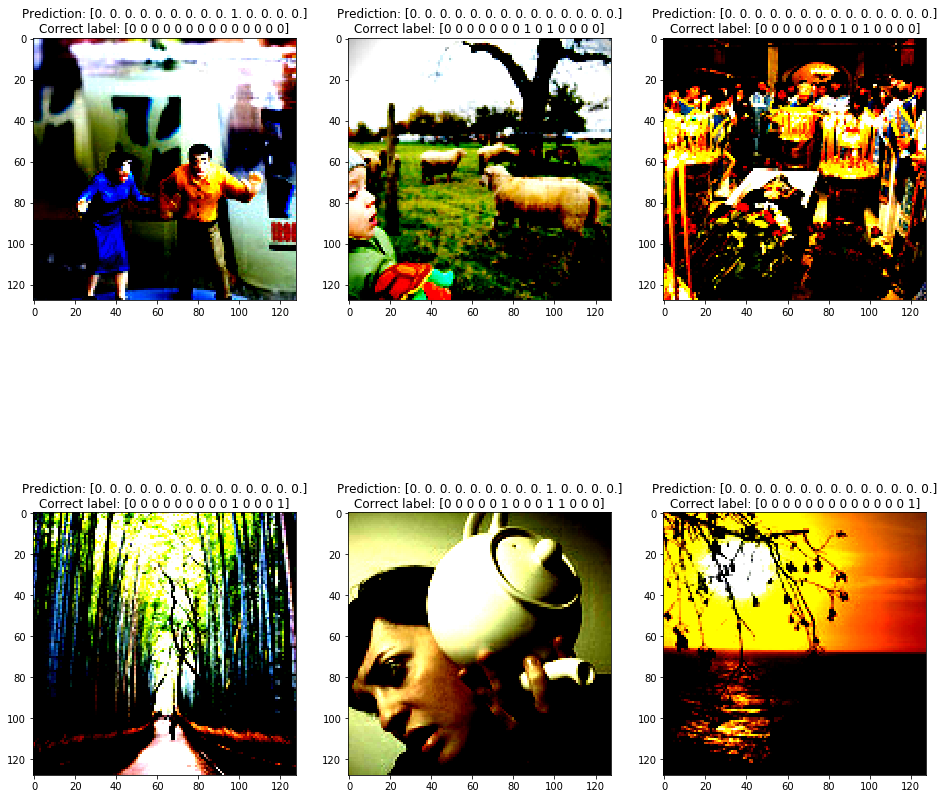

In [43]:
wrong = tdata[((pred!=labels).numpy().any(1))]
wrong_labels = pred[(pred!=labels).numpy().any(1)]
right_labels=labels[(pred!=labels).numpy().any(1)]
fig = plt.figure(figsize=(16,16))
for i in range(6):
    plt.subplot(231+i)
    plt.title(f'Prediction: {wrong_labels[i]}\nCorrect label: {right_labels[i]}')
    plt.imshow(wrong[i])

plt.show()

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

In [3]:
test_root ='image-test-corpus'+os.sep+'images'

ims = []
datasetsize = len( os.listdir(test_root))
for file in os.listdir(test_root):
    path = test_root + os.sep + file
    ims.append(path)
    
ims = np.array(ims)

In [4]:
datasetsize

5000

In [7]:
ds = tf.data.Dataset.from_tensor_slices(ims)

ds = ds.map(tf.io.read_file)

ds = ds.map(decode_img).batch(32)

# for d in ds:
#     plt.imshow(d)
#     plt.show()

In [6]:
model = tfk.models.load_model('model')

In [8]:
y=model.predict(ds)

In [14]:
y[y>=0.5]=1
y[y<0.5]=0

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

If you have the prediction output matrix prepared in `y` you can use the following function to save it to a text file.

In [15]:
np.savetxt('results.txt', y, fmt='%d')